In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

df = pd.read_csv('EngineData.csv')

dataset = tf.data.Dataset.from_tensor_slices((df['Fuel Flow'], df['RPM'], df['Emissions']))

In [ ]:
import pandas as pd
import tensorflow as tf

df = pd.read_csv('EngineData.csv')

df['RPM_mean'] = df['RPM'].rolling(window=20).mean()
df['RPM_stddev'] = df['RPM'].rolling(window=20).std()
df['Thrust_mean'] = df['Thrust'].rolling(window=20).mean()
df['Thrust_stddev'] = df['Thrust'].rolling(window=20).std()

df['RPM_upper'] = df['RPM_mean'] + (df['RPM_stddev'] * 2)
df['RPM_lower'] = df['RPM_mean'] - (df['RPM_stddev'] * 2)
df['Thrust_upper'] = df['Thrust_mean'] + (df['Thrust_stddev'] * 2)
df['Thrust_lower'] = df['Thrust_mean'] - (df['Thrust_stddev'] * 2)

data = df[['RPM', 'Thrust', 'Fuel Flow', 'Oil Pressure', 'Oil Temperature', 'Coolant Temperature', 'Engine Temperature', 'Vibration', 'EGT', 'Flight Conditions', 'Environmental Factors', 'Emissions', 'RPM_mean', 'RPM_upper', 'RPM_lower', 'Thrust_mean', 'Thrust_upper', 'Thrust_lower']]

dataset = tf.data.Dataset.from_tensor_slices((data[['RPM', 'Thrust', 'Fuel Flow', 'Oil Pressure', 'Oil Temperature', 'Coolant Temperature', 'Engine Temperature', 'Vibration', 'EGT', 'RPM_mean', 'RPM_upper', 'RPM_lower', 'Thrust_mean', 'Thrust_upper', 'Thrust_lower']], data['Emissions']))

dataset = dataset.shuffle(buffer_size=10000).batch(32)

print(df)


          Date      Time   RPM  Thrust  Fuel Flow  Oil Pressure  \
0   2023-04-29   8:00:00  2000   12700         10            50   
1   2023-04-29   8:15:00  2500   15400         15            60   
2   2023-04-29   8:30:00  3000   18100         20            70   
3   2023-04-29   8:45:00  3500   20800         25            80   
4   2023-04-29   9:00:00  4000   23500         30            90   
5   2023-04-29   9:15:00  4200   25000         32            95   
6   2023-04-29   9:30:00  4500   28000         35           100   
7   2023-04-29   9:45:00  4800   31500         40           110   
8   2023-04-29  10:00:00  5000   34000         45           120   
9   2023-04-29  10:15:00  5500   36700         50           130   
10  2023-04-29  10:30:00  6000   39400         55           140   
11  2023-04-29  10:45:00  6500   42100         60           150   

    Oil Temperature  Coolant Temperature  Engine Temperature  Vibration  ...  \
0                50                   50        

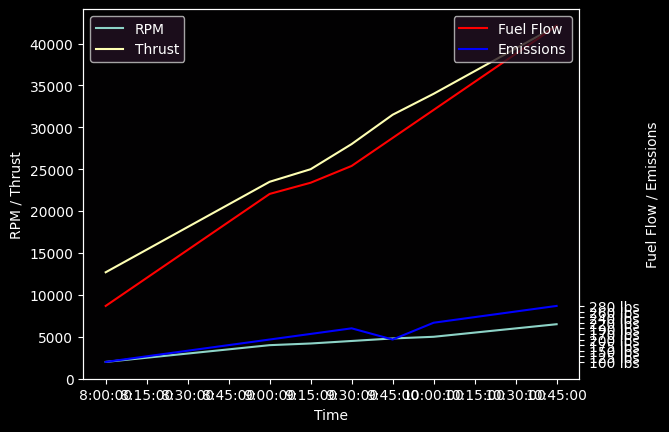

In [ ]:
import matplotlib.pyplot as plt


custom_color = '#2121'

plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = custom_color

df['Fuel Flow'] = pd.to_numeric(df['Fuel Flow'])

fig, ax1 = plt.subplots()

ax1.plot(df['Time'], df['RPM'], label='RPM')
ax1.plot(df['Time'], df['Thrust'], label='Thrust')

ax2 = ax1.twinx()
ax2.plot(df['Time'], df['Fuel Flow'], color='red', label='Fuel Flow')
ax2.plot(df['Time'], df['Emissions'], color='blue', label='Emissions')

ax1.set_xlabel('Time')
ax1.set_ylabel('RPM / Thrust')
ax2.set_ylabel('Fuel Flow / Emissions')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

#FIX TIME STAMP


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

x = np.column_stack((data['RPM'], data['Fuel Flow']))
y = data['Emissions'].str.extract('(\d+\.?\d*)').astype(float).values

scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

model.compile(
    loss='mean_squared_error',
    optimizer=tf.keras.optimizers.Adam(0.0005),
    metrics=['mse']
)



model.fit(
    x_train,
    y_train,
    epochs=250,
    batch_size=24,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping]
)

test_loss, test_mse = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test MSE:', test_mse)

Epoch 1/250
1/1 [==============================] - 1s 1s/step - loss: 38601.5781 - mse: 38601.5781 - val_loss: 42772.2227 - val_mse: 42772.2227
Epoch 2/250
1/1 [==============================] - 0s 47ms/step - loss: 38569.2188 - mse: 38569.2188 - val_loss: 42746.0508 - val_mse: 42746.0508
Epoch 3/250
1/1 [==============================] - 0s 47ms/step - loss: 38545.7227 - mse: 38545.7227 - val_loss: 42720.7617 - val_mse: 42720.7617
Epoch 4/250
1/1 [==============================] - 0s 65ms/step - loss: 38522.9375 - mse: 38522.9375 - val_loss: 42693.1250 - val_mse: 42693.1250
Epoch 5/250
1/1 [==============================] - 0s 46ms/step - loss: 38497.9062 - mse: 38497.9062 - val_loss: 42661.0195 - val_mse: 42661.0195
Epoch 6/250
1/1 [==============================] - 0s 45ms/step - loss: 38468.9258 - mse: 38468.9258 - val_loss: 42624.6133 - val_mse: 42624.6133
Epoch 7/250
1/1 [==============================] - 0s 48ms/step - loss: 38435.9844 - mse: 38435.9844 - val_loss: 42582.8320 - 

Average Loss = 73.44526666666667